In [1]:
from nmf import NMFProblemKLInstance, NMFProblemFroInstance
import numpy as np
import scipy
from scipy.optimize import minimize, Bounds
import time
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

In [2]:
class BaseOptimizer(ABC):
    """Abstract base class for all optimizers."""
    def __init__(self, name, options=None):
        self.name = name
        self.options = options if options is not None else {}
        self.history = []
        self.solve_time = 0.0
        self.max_iters = self.options.get('maxiter', 200)

    @abstractmethod
    def solve(self, problem, w0):
        """
        Solves the given problem starting from w0.
        Must populate self.history with the loss at each iteration.
        """
        pass

    def __str__(self):
        return f"{self.name} (Time: {self.solve_time:.2f}s)"

In [3]:
class ScipyOptimizer(BaseOptimizer):
    """Wrapper for scipy.optimize.minimize methods."""
    def __init__(self, name, method, options=None):
        super().__init__(name, options)
        self.method = method
        self.result = None
        self._problem = None # To store problem for callback

    def _callback(self, xk, *args):
        """Internal callback to store history."""
        loss = self._problem.objective(xk)
        self.history.append(loss)

    def solve(self, problem, w0):
        self._problem = problem # Store problem for callback
        self.history = [problem.objective(w0)] # Initial loss
        
        num_vars = w0.size
        bounds = Bounds(lb=np.zeros(num_vars), ub=np.inf)
        
        # Build arguments for minimize
        kwargs = {
            'fun': problem.objective,
            'x0': w0,
            'method': self.method,
            'jac': problem.gradient,
            'bounds': bounds,
            'callback': self._callback,
            'options': self.options
        }
        
        # Add hessian if method supports it (like trust-constr)
        if self.method == 'trust-constr':
            kwargs['hess'] = problem.full_hessian
        
        print(f"\n--- Running {self.name} ---")
        start_time = time.time()
        self.result = minimize(**kwargs)
        self.solve_time = time.time() - start_time
        
        print(self.result.message)
        print(f"--- {self.name} finished in {self.solve_time:.2f} seconds ---")

In [4]:
class CustomARAOptimizer(BaseOptimizer):
    """Implements the custom 'ARA' optimization algorithm."""
    def __init__(self, name, options=None):
        super().__init__(name, options)
        self.kappa = self.options.get('kappa', 1.0)
        self.ell = self.options.get('ell', 1.0)
        self.gammas = self.options.get('gammas', (0.5, 2.0, 2.0))
        self.etas = self.options.get('etas', (0.01, 0.9))

    def solve(self, problem, w0):
        print(f"\n--- Running {self.name} ---")
        start_time = time.time()
        
        # Dynamically get the correct regularizer from the problem
        reg_class = problem.get_regularizer_class()
        reg_problem = reg_class(problem.Z, problem.r)
        
        w = w0.copy()
        self.history = []
        
        ell = self.ell
        kappa = self.kappa
        gamma1, gamma2, gamma3 = self.gammas
        eta1, eta2 = self.etas
        
        for k in range(self.max_iters):
            obj_old = problem.objective(w)
            self.history.append(obj_old)
            g = problem.gradient(w)
            
            # Use the problem's regularizer to get the Hessian
            reg_hess_diag = reg_problem.hessian(w, ell) # Assumes this returns 1D array
            if len(np.shape(reg_hess_diag)) == 1:
                H_sc = problem.full_hessian(w) + np.diag(reg_hess_diag)
            else:
                H_sc = problem.full_hessian(w) + reg_hess_diag

            flag = False
            rho = -1
            obj_new = np.inf
            w_new = w

            try:
                d = scipy.linalg.solve(H_sc, -g, assume_a='sym')
                lam = np.dot(d, -g)
                if lam >= 0:
                    w_new = w + d / (1 + kappa * np.sqrt(lam))
                    if np.sum(w_new < 0) > 0: # Enforce non-negativity
                        flag = True
                        obj_new_val = np.nan
                    else:
                        obj_new_val = problem.objective(w_new)
                    if not (np.isinf(obj_new_val) or np.isnan(obj_new_val)):
                        obj_new = obj_new_val
                        model_decrease = (kappa * lam - np.log(1 + kappa * lam)) / kappa**2
                        rho = (obj_old - obj_new) / (model_decrease + 1e-12)
                    else:
                        flag = True
            except (np.linalg.LinAlgError, ValueError):
                flag = True

            if (k + 1) % 20 == 0 or k == 0:
                print(f"Iter {k+1:4} | Loss: {obj_old:.8f} | Rho: {rho:.4f} | ell: {ell:.4f} | kappa: {kappa:.4f}")

            if not flag and rho >= eta1:
                w = w_new
            elif abs(obj_old - obj_new) < 1e-8:
                print(f"\nConverged at iteration {k+1} due to small change in objective.")
                break

            if not flag:
                if rho > eta2: ell = gamma1 * ell
                elif rho < eta1: ell = gamma2 * ell
            else:
                ell = gamma3 * ell
        
        self.solve_time = time.time() - start_time
        print(f"--- {self.name} finished in {self.solve_time:.2f} seconds ---")

In [5]:
class CustomARCOptimizerBound(BaseOptimizer):
    """Implements the custom 'ARC' (cubic regularization) algorithm."""
    def __init__(self, name, options=None):
        super().__init__(name, options)
        self.sigma = self.options.get('sigma', 1.0)
        self.gammas = self.options.get('gammas', (0.5, 2.0, 2.0))
        self.etas = self.options.get('etas', (0.01, 0.9))
        self.mu = self.options.get('mu', 1e-6)
        self.eps = self.options.get('eps', 1e-9)
        # Internal state for subproblem
        self._g = None
        self._H = None
        self._sigma_current = None

    # --- Helper methods for the cubic subproblem ---
    def _subproblem_m(self, dx):
        norm_dx = np.linalg.norm(dx)
        return np.dot(self._g, dx) + 0.5 * np.dot(dx, self._H @ dx) + (self._sigma_current / 3.0) * norm_dx**3

    def _subproblem_grad(self, dx):
        r = np.linalg.norm(dx)
        if r < 1e-9: return self._g + self._H @ dx
        return self._g + self._H @ dx + self._sigma_current * r * dx

    def _subproblem_hess(self, dx):
        r = np.linalg.norm(dx)
        n = len(dx)
        if r < 1e-9: return self._H
        dx_outer = np.outer(dx, dx)
        return self._H + self._sigma_current * (r * np.eye(n) + dx_outer / r)
    # --- End of helpers ---

    def solve(self, problem, w0):
        print(f"\n--- Running {self.name} ---")
        start_time = time.time()
        
        w = w0.copy()
        self.history = []
        
        self._sigma_current = self.sigma
        gamma1, gamma2, gamma3 = self.gammas
        eta1, eta2 = self.etas
        
        for k in range(self.max_iters):
            obj_old = problem.objective(w) - self.mu * np.sum(np.log(w + self.eps))
            true_obj = problem.objective(w)
            self.history.append(true_obj)
            
            self._g = problem.gradient(w) - self.mu / (w + self.eps)
            self._H = problem.full_hessian(w) + self.mu * np.diag(1/((w + self.eps)**2))
            
            flag = False
            rho = -1
            obj_new = np.inf
            w_new = w

            try:
                d_init = scipy.linalg.solve(self._H, -self._g, assume_a='sym')
                res = minimize(
                    self._subproblem_m, 
                    d_init, 
                    method="Newton-CG", 
                    jac=self._subproblem_grad, 
                    hess=self._subproblem_hess,
                    options={'maxiter': 50} # Inner loop limit
                )
                
                d = res.x
                w_new = w + d
                
                if np.sum(w_new < 0) > 0: # Enforce non-negativity
                    flag = True
                    obj_new_val = np.nan
                else:
                    obj_new_val = problem.objective(w_new) - self.mu * np.sum(np.log(w_new + self.eps))
                if not (np.isinf(obj_new_val) or np.isnan(obj_new_val)):
                    obj_new = obj_new_val
                    model_decrease = -res.fun
                    rho = (obj_old - obj_new) / (model_decrease + 1e-12)
                else:
                    flag = True
            except (np.linalg.LinAlgError, ValueError):
                flag = True

            if (k + 1) % 20 == 0 or k == 0:
                print(f"Iter {k+1:4} | Loss: {true_obj:.8f} | Rho: {rho:.4f} | sigma: {self._sigma_current:.4f}")

            if not flag and rho >= eta1:
                w = w_new
            elif abs(obj_old - obj_new) < 1e-8:
                print(f"\nConverged at iteration {k+1} due to small change in objective.")
                break

            if not flag:
                if rho > eta2: self._sigma_current = gamma1 * self._sigma_current
                elif rho < eta1: self._sigma_current = gamma2 * self._sigma_current
            else:
                self._sigma_current = gamma3 * self._sigma_current
        
        self.solve_time = time.time() - start_time
        print(f"--- {self.name} finished in {self.solve_time:.2f} seconds ---")

In [6]:
import matplotlib.pyplot as plt

class NMFExperimentRunner:
    def __init__(self, problem):
        self.problem = problem
        self.optimizers = []
        self.title = f"Convergence Comparison for NMF ({problem.get_problem_name()})"
        self.ylabel = problem.get_loss_name()

    def add_optimizer(self, optimizer):
        """Adds an optimizer instance to the experiment."""
        self.optimizers.append(optimizer)
        
    def run_all(self):
        """Runs all registered optimizers on the problem."""
        print(f"\n{'='*40}")
        print(f"=== Starting Experiment: {self.problem.get_problem_name()} ===")
        print(f"=== Problem: Z=({self.problem.m}x{self.problem.n}), Rank r={self.problem.r} ===")
        print(f"=== Initial Loss: {self.problem.objective(self.problem.w0):.8f} ===")
        print(f"{'='*40}")
        
        for opt in self.optimizers:
            # Pass a copy of w0 so each optimizer starts fresh
            opt.solve(self.problem, self.problem.w0.copy())
            
    def plot_results(self):
        """Plots the convergence history of all optimizers."""
        plt.style.use('seaborn-v0_8-whitegrid')
        plt.figure(figsize=(12, 8))
        
        markers = ['o', 'x', 's', 'D']
        linestyles = ['-', '--', ':', '-.']

        for i, opt in enumerate(self.optimizers):
            plt.plot(
                opt.history, 
                label=f"{opt.name}", 
                marker=markers[i % len(markers)], 
                linestyle=linestyles[i % len(linestyles)], 
                markersize=4
            )
        
        plt.title(self.title, fontsize=20)
        plt.xlabel('Iteration', fontsize=16)
        plt.ylabel(self.ylabel, fontsize=16)
        plt.yscale('log') 
        plt.legend(fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.grid(True, which="both", ls="--")
        plt.tight_layout()
        plt.show()

In [7]:
max_iters = 200
common_options = {'maxiter': max_iters}

optimizers_to_run = [
    ScipyOptimizer(
        name="L-BFGS-B (scipy)", 
        method="L-BFGS-B", 
        options=common_options
    ),
    ScipyOptimizer(
        name="trust-constr (scipy)",
        method="trust-constr",
        options=common_options
    ),
    CustomARAOptimizer(
        name="ARA",
        options={**common_options, 'kappa': 1.0, 'ell': 1.0}
    ),
    CustomARCOptimizerBound(
        name=r"ARC $\mu=0$",
        options={**common_options, 'sigma': 1.0, 'mu': 0.0}
    ),
    CustomARCOptimizerBound(
        name=r"ARC $\mu=10^{-5}$",
        options={**common_options, 'sigma': 1.0, 'mu': 1e-5}
    ),
    CustomARCOptimizerBound(
        name=r"ARC $\mu=10^{-6}$",
        options={**common_options, 'sigma': 1.0, 'mu': 1e-6}
    ),
    CustomARCOptimizerBound(
        name=r"ARC $\mu=10^{-7}$",
        options={**common_options, 'sigma': 1.0, 'mu': 1e-7}
    )
]
# %%
# --- 3. SETUP SYNTHETIC DATA ---
m, n, r = 100, 20, 10
print(f"Creating a synthetic problem of size Z=({m}x{n}) with rank r={r}\n")
X_true = np.random.rand(m, r)
Y_true = np.random.rand(r, n)
Z_data = np.abs(X_true @ Y_true + 0.01 * (np.random.rand(m, n) - 0.5))
seed = 42

Creating a synthetic problem of size Z=(100x20) with rank r=10




=== Starting Experiment: KL Divergence ===
=== Problem: Z=(100x20), Rank r=10 ===
=== Initial Loss: 0.20920591 ===

--- Running L-BFGS-B (scipy) ---
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT
--- L-BFGS-B (scipy) finished in 0.05 seconds ---

--- Running trust-constr (scipy) ---


/home/zjy/nmf/nmf/KLInstance.py:40: RuntimeWarning: invalid value encountered in log
  return np.mean(Z_temp * np.log(Z_temp / XY) - Z_temp + XY)


The maximum number of function evaluations is exceeded.
--- trust-constr (scipy) finished in 14.18 seconds ---

--- Running ARA ---
Iter    1 | Loss: 0.20920591 | Rho: 34.2481 | ell: 1.0000 | kappa: 1.0000
Iter   20 | Loss: 0.00087139 | Rho: 7490.1361 | ell: 0.0005 | kappa: 1.0000
Iter   40 | Loss: 0.00012969 | Rho: -1.0000 | ell: 0.0000 | kappa: 1.0000
Iter   60 | Loss: 0.00003010 | Rho: 117658.7054 | ell: 0.0000 | kappa: 1.0000
Iter   80 | Loss: 0.00000090 | Rho: 47280.9602 | ell: 0.0000 | kappa: 1.0000

Converged at iteration 88 due to small change in objective.
--- ARA finished in 15.02 seconds ---

--- Running ARC $\mu=0$ ---
Iter    1 | Loss: 0.20920591 | Rho: 1.4463 | sigma: 1.0000
Iter   20 | Loss: 0.15230593 | Rho: -1.0000 | sigma: 2048.0000
Iter   40 | Loss: 0.15216611 | Rho: -1.0000 | sigma: 536870912.0000
Iter   60 | Loss: 0.15216611 | Rho: -1.0000 | sigma: 562949953421312.0000
Iter   80 | Loss: 0.15216611 | Rho: -1.0000 | sigma: 590295810358705651712.0000
Iter  100 | Loss:

/home/zjy/nmf/venv/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.34623e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


Iter  160 | Loss: 0.00013999 | Rho: -1.0000 | sigma: 0.0000


/home/zjy/nmf/venv/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.14033e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/home/zjy/nmf/venv/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=7.67471e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


Iter  180 | Loss: 0.07948536 | Rho: 1.1504 | sigma: 0.0000


/home/zjy/nmf/venv/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=7.61352e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/home/zjy/nmf/venv/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=7.61352e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/home/zjy/nmf/venv/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.17561e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/home/zjy/nmf/venv/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.27607e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/home/zjy/nmf/venv/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.97188e-17): result may not be accurate.
  return f(*arrays, *ot

Iter  200 | Loss: 0.00011405 | Rho: 0.0008 | sigma: 0.0000
--- ARC $\mu=10^{-5}$ finished in 84.60 seconds ---

--- Running ARC $\mu=10^{-6}$ ---
Iter    1 | Loss: 0.20920591 | Rho: 1.4463 | sigma: 1.0000
Iter   20 | Loss: 0.09740959 | Rho: -1.0000 | sigma: 32.0000
Iter   40 | Loss: 0.03534865 | Rho: 1.4268 | sigma: 0.1250
Iter   60 | Loss: 0.00313835 | Rho: 1.4131 | sigma: 0.0005
Iter   80 | Loss: 0.00002058 | Rho: -1.0000 | sigma: 0.0000
Iter  100 | Loss: 0.00001125 | Rho: 1.0072 | sigma: 0.0000
Iter  120 | Loss: 0.00000548 | Rho: 1.3224 | sigma: 0.0000
Iter  140 | Loss: 0.00000341 | Rho: 1.1796 | sigma: 0.0000
Iter  160 | Loss: 0.00000263 | Rho: 1.4732 | sigma: 0.0000
Iter  180 | Loss: 0.00000285 | Rho: 1.4764 | sigma: 0.0000
Iter  200 | Loss: 0.00000439 | Rho: 1.4482 | sigma: 0.0000
--- ARC $\mu=10^{-6}$ finished in 80.91 seconds ---

--- Running ARC $\mu=10^{-7}$ ---
Iter    1 | Loss: 0.20920591 | Rho: 1.4463 | sigma: 1.0000
Iter   20 | Loss: 0.14123861 | Rho: 1.4910 | sigma: 32.0

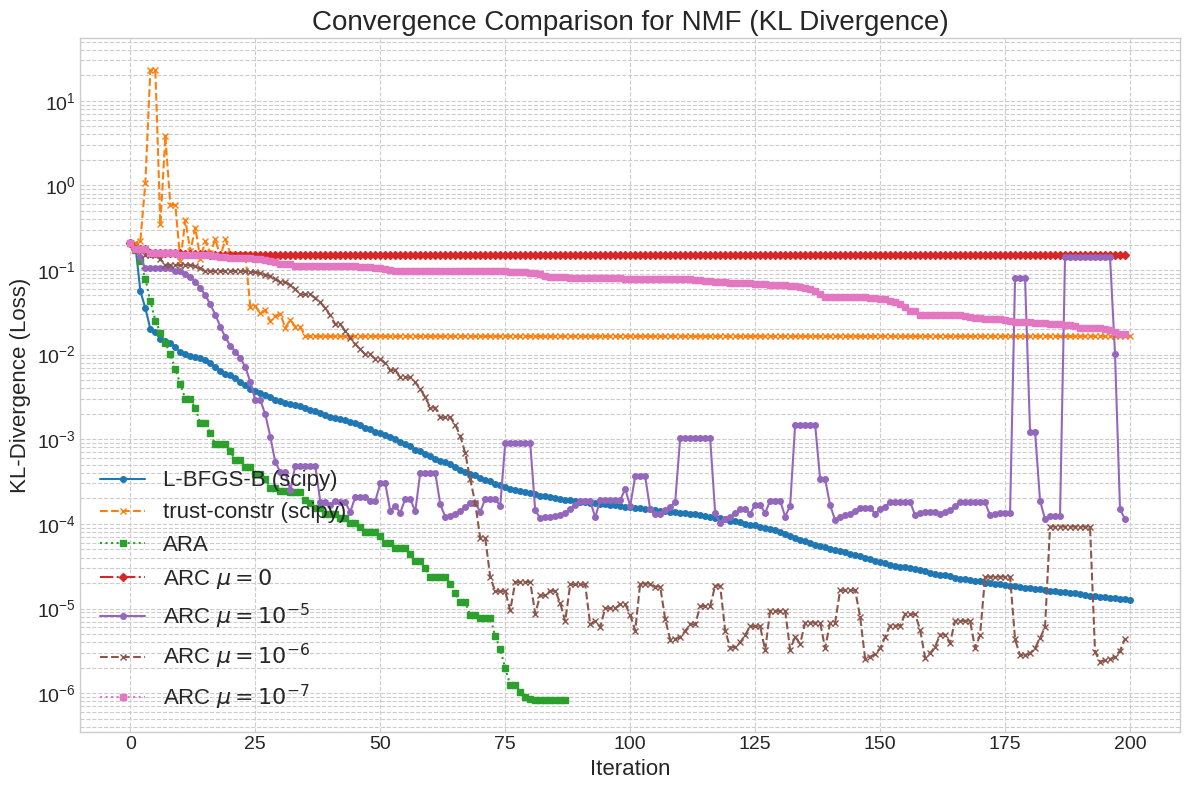

In [8]:
problem_kl = NMFProblemKLInstance(Z_data, r, seed=seed)
experiment_kl = NMFExperimentRunner(problem_kl)

for opt in optimizers_to_run:
    experiment_kl.add_optimizer(opt)
    
experiment_kl.run_all()
experiment_kl.plot_results()


=== Starting Experiment: Frobenius Norm (MSE) ===
=== Problem: Z=(100x20), Rank r=10 ===
=== Initial Loss: 0.54609683 ===

--- Running L-BFGS-B (scipy) ---
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT
--- L-BFGS-B (scipy) finished in 0.03 seconds ---

--- Running trust-constr (scipy) ---
The maximum number of function evaluations is exceeded.
--- trust-constr (scipy) finished in 4.65 seconds ---

--- Running ARA ---
Iter    1 | Loss: 0.54609683 | Rho: 39816.2675 | ell: 1.0000 | kappa: 1.0000
Iter   20 | Loss: 0.02909076 | Rho: -1.0000 | ell: 0.0000 | kappa: 1.0000
Iter   40 | Loss: 0.00911977 | Rho: 1412.0338 | ell: 0.0000 | kappa: 1.0000
Iter   60 | Loss: 0.00236241 | Rho: -1.0000 | ell: 0.0000 | kappa: 1.0000
Iter   80 | Loss: 0.00025458 | Rho: -1.0000 | ell: 0.0000 | kappa: 1.0000
Iter  100 | Loss: 0.00000208 | Rho: 104957.9200 | ell: 0.0000 | kappa: 1.0000

Converged at iteration 105 due to small change in objective.
--- ARA finished in 3.83 seconds ---

--- Running ARC $\mu=0$ ---

/home/zjy/nmf/venv/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=8.0615e-18): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


Iter  200 | Loss: 0.00029914 | Rho: 1.0377 | sigma: 0.0000
--- ARC $\mu=10^{-5}$ finished in 53.97 seconds ---

--- Running ARC $\mu=10^{-6}$ ---
Iter    1 | Loss: 0.54609683 | Rho: 1.4238 | sigma: 1.0000
Iter   20 | Loss: 0.32492996 | Rho: -1.0000 | sigma: 128.0000
Iter   40 | Loss: 0.24631190 | Rho: -1.0000 | sigma: 2048.0000
Iter   60 | Loss: 0.18825263 | Rho: 1.4736 | sigma: 8.0000
Iter   80 | Loss: 0.07717774 | Rho: 1.4393 | sigma: 0.5000
Iter  100 | Loss: 0.02094914 | Rho: -1.0000 | sigma: 0.0312
Iter  120 | Loss: 0.00417150 | Rho: -1.0000 | sigma: 0.0005
Iter  140 | Loss: 0.00004760 | Rho: -1.0000 | sigma: 0.0001
Iter  160 | Loss: 0.00004030 | Rho: -1.0000 | sigma: 0.0000
Iter  180 | Loss: 0.00000520 | Rho: 1.2527 | sigma: 0.0000
Iter  200 | Loss: 0.00001342 | Rho: 0.2827 | sigma: 0.0001
--- ARC $\mu=10^{-6}$ finished in 48.57 seconds ---

--- Running ARC $\mu=10^{-7}$ ---
Iter    1 | Loss: 0.54609683 | Rho: 1.4238 | sigma: 1.0000
Iter   20 | Loss: 0.40793827 | Rho: -1.0000 | si

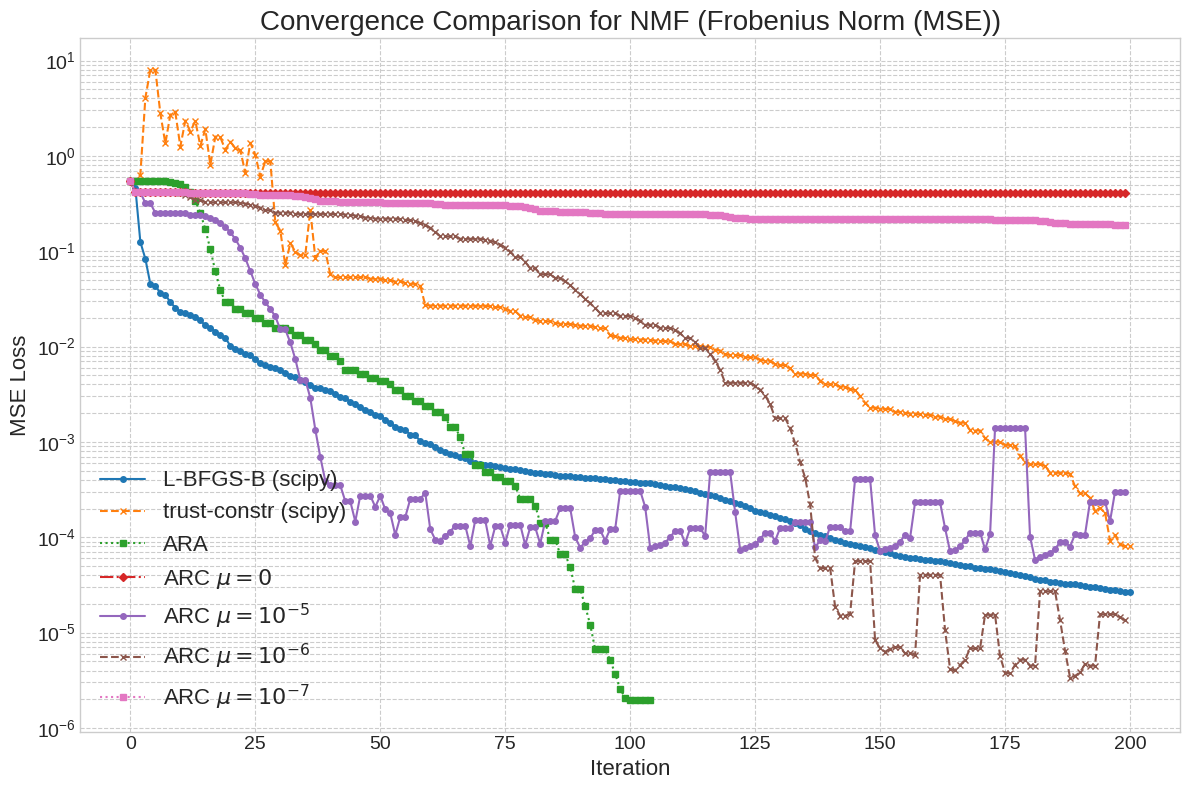

In [9]:
problem_fro = NMFProblemFroInstance(Z_data, r, seed=seed)
experiment_fro = NMFExperimentRunner(problem_fro)

for opt in optimizers_to_run:
    experiment_fro.add_optimizer(opt)

experiment_fro.run_all()
experiment_fro.plot_results()